In [2]:
import os
import numpy as np
import pandas as pd
import json
os.environ["NAMESPACE"]="research"
os.environ["PROFILE"]="local"
from agrobrain_util.runtime.evironment import RuntimeEnv
from agrobrain_util.infra.app_config import application_config as cfg

import shutil
import glob
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from shapely.geometry import Point, Polygon

import json
import random
import glob
import datetime
from tqdm import tqdm
from datetime import datetime

from skimage.transform import resize
from skimage.filters import gaussian
import skimage.measure

from PIL import Image

import dtlpy as dl
if dl.token_expired():
    dl.login()

env = RuntimeEnv()
DATA_DIR = "data"
project = dl.projects.get(project_name='Taranis AI Annotation Projects')


could not find stamp in environment variables
could not find stamp in environment variables
could not find KUBEFLOW_API_BASIC_AUTH_TOKEN in environment variables
could not find AI_RABBITMQ_CONNECTION_STRING in environment variables
could not find AI_MONGO_DB_CONNECTION_STRING in environment variables
could not find TARANIS_DB_CONNECTION_STRING in environment variables
could not find GLOBAL_DB_CONNECTION_STRING in environment variables
could not find AI_MONGO_DB_CONNECTION_STRING_NEW in environment variables


In [3]:
# READ ANNOTATIONS

def get_jsons_paths_list(dataset_name, task_name, version, sub_folder=""):
    dataloop_local_data_dir = os.path.join(DATA_DIR, f"dataloop")
    annotation_local_path = os.path.join(dataloop_local_data_dir, f"annotations_{dataset_name}_task_{task_name}_v{version}")
    if sub_folder=="":
        jsons_folder = os.path.join(annotation_local_path, "json")
    else:
        jsons_folder = os.path.join(annotation_local_path, "json", sub_folder)
    jsons_paths_list = glob.glob(os.path.join(jsons_folder, "*.json"))
    return jsons_paths_list


# POINT TAGS


POINTS_DATASET_NAME = "anafa_2023_07_11_resolution_limitation_5_res"
POINTS_TASK_NAME = 'anafa_2023_07_11_resolution_limitation_5_res'
POINTS_VERSION = 0

# download_datasets_annotations_from_dataloop(POINTS_DATASET_NAME, POINTS_TASK_NAME, POINTS_VERSION)
points_jsons_paths_list = get_jsons_paths_list(POINTS_DATASET_NAME, POINTS_TASK_NAME, POINTS_VERSION, sub_folder="resized_images")
points_task = project.tasks.get(task_name=POINTS_TASK_NAME)


POLYGONS_DATASET_NAME = "anafa_2023_06_23_resolution_lim_dataset_1"
POLYGONS_TASK_NAME = 'anafa_2023_06_23_resolution_lim_first_task_01'
POLYGONS_VERSION = 0

# download_datasets_annotations_from_dataloop(POLYGONS_DATASET_NAME, POLYGONS_TASK_NAME, POLYGONS_VERSION)
polygons_jsons_paths_list = get_jsons_paths_list(POLYGONS_DATASET_NAME, POLYGONS_TASK_NAME, POLYGONS_VERSION)
polygons_task = project.tasks.get(task_name=POLYGONS_TASK_NAME)


points_task_image_ids_list = np.unique([int(os.path.basename(p).split("_")[0]) for p in points_jsons_paths_list])
filtered_polygons_jsons_paths_list = [elem for elem in polygons_jsons_paths_list if any(str(id_) in os.path.basename(elem) for id_ in points_task_image_ids_list)]

print(f"len points_jsons_paths_list:{len(points_jsons_paths_list)}, len polygons_jsons_paths_list: {len(polygons_jsons_paths_list)}, len filtered_polygons_jsons_paths_list: {len(filtered_polygons_jsons_paths_list)}")


len points_jsons_paths_list:4950, len polygons_jsons_paths_list: 1000, len filtered_polygons_jsons_paths_list: 990


In [5]:
width_factor, height_factor

(7.657311669128508, 7.653543307086614)

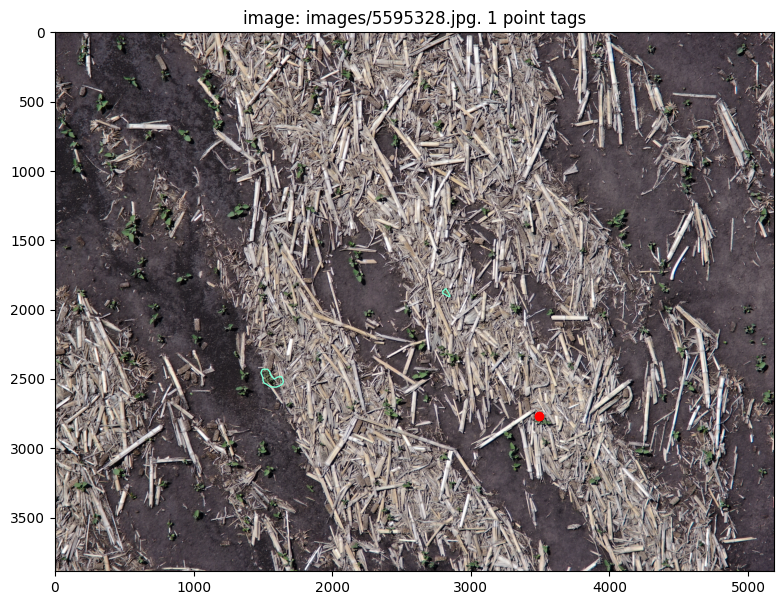

In [78]:
# EXAMPLE - DISPLAY ONE IMAGE TAGS

example_image_id = 5233797
example_im_path = env.download_image(int(example_image_id))
example_image = io.imread(example_im_path)
original_image_width = example_image.shape[1]
original_image_height = example_image.shape[0]

# image_id = points_task_image_ids_list[15] 
image_id = 5595328
# image_id = 6580458
# image_id = 9445268
points_tags_jsons = [path for path in points_jsons_paths_list if str(image_id) in path]
polygons_tags_json = [path for path in polygons_jsons_paths_list if str(image_id) in path][0]


im_path = env.download_image(int(image_id))
image = io.imread(im_path)




with open(polygons_tags_json) as file:
    polygons_json_data = json.load(file)



fig, ax = plt.subplots(figsize=(14,7))

ax.imshow(image)

shapely_polygons = []

# DRAW POLYGONS
for i in range(len(polygons_json_data['annotations'])):
    x_values = [coord['x'] for coord in polygons_json_data['annotations'][i]['coordinates'][0]]
    y_values = [coord['y'] for coord in polygons_json_data['annotations'][i]['coordinates'][0]]
    polygon = patches.Polygon(list(zip(x_values, y_values)), closed=True, fill=None, edgecolor='aquamarine')
    shapely_polygons.append(Polygon(list(zip(x_values, y_values))))
    ax.add_patch(polygon)
    ax.set_title(f"image: {im_path}")


# DRAW POINTS
for points_tags_json in points_tags_jsons:
    with open(points_tags_json) as file:
        points_json_data = json.load(file)


    for i in range(len(points_json_data['annotations'])):
        width = points_json_data['metadata']['system']['width']
        height = points_json_data['metadata']['system']['height']

        width_factor = original_image_width / width
        height_factor = original_image_height / height

        x_value = int(points_json_data['annotations'][i]['coordinates']['x']) * width_factor
        y_value = int(points_json_data['annotations'][i]['coordinates']['y']) * height_factor

        shapely_point = Point(x_value, y_value)

        is_inside = np.any([poly.contains(shapely_point) for poly in shapely_polygons])
        if is_inside:
            point_color = 'mo'
        else:
            point_color = 'ro'

        ax.plot(x_value, y_value, point_color)

        # ax.set_xlim(1800, 2300)
        # ax.set_ylim(1500, 1000)
        # ax.set_xlim(1800, 2100)
        # ax.set_ylim(2800, 2500)


        ax.set_title(f"image: {im_path}. {len(points_json_data['annotations'])} point tags")


plt.show()